# "Segmentez des clients d'un site e-commerce"
_Cleaning Notebook_

## 0 Preliminaries

In [ ]:
# !pip install flake8 pycodestyle_magic
# !pip install gtts
# !pip install category-encoders
# !pip install mlxtend==0.17.3 # makes Google Colab asking for reboot
# !pip install ppscore

In [ ]:
# !pip freeze > requirements_cleaning_eda.txt

Checking for PEP8 compliance

In [ ]:
# %load_ext pycodestyle_magic
# %pycodestyle_on
# %pycodestyle_off

### 0.0 Importing Packages and Modules

Checking whether the notebook is on Colab or PC

In [296]:
import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

Mounting my Drive if on colab

In [298]:
if is_colab==True:
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
You're on Google Colab


Installations and importations required in the virtual environment.

In [299]:
import os
if is_colab==True:
    if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS':
        os.chdir('My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS')
else:
    if not (os.path.exists(os.getcwd()+'/requirements_cleaning_eda.txt') \
                     and os.path.exists(os.getcwd()+'/P5_functions.py')):
        print("ERROR: Make sure 'P5_functions.py' and 'requirements_cleaning_eda.txt' are in the current working directory")

!pip install -r requirements_cleaning_eda.txt
from P5_functions import *

Importation of modules and packages. 

In [ ]:
import io
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

Setting pandas display options

In [ ]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                    'display.max_colwidth': 100,
                    'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

To play audio text-to-speech during execution.

In [ ]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [ ]:
speak('Packages and modules successfully imported')

### 0.1 Importing the Aggregated Orders dataset

Let's load the dataframe of aggregated orders as well as the dataframe of aggregated customers.

This way, we'll be able to reconstruct the dataframe of customer on different slots of time later on.

In [ ]:
if is_colab==True:
    # Importing database from my Drive
    print("Try to import data files in the notebook from myDrive...")
else:
    # Importing database from PC
    print("Try to import data files in the notebook from PC ('DATA')...")

df_cust = pd.read_csv('agg_customers.csv', sep=',', index_col='customer_unique_id',
                        encoding ='utf-8').drop(columns=['Unnamed: 0'])

df_orders = pd.read_csv('agg_orders.csv', sep=',', index_col='order_id',
                        encoding ='utf-8').drop(columns=['Unnamed: 0'])

print("-----> Importation of .csv in the notebook: OK")

Try to import data files in the notebook from myDrive...
-----> Importation of .csv in the notebook: OK


All the dates and timestamps in the dataframes are to be converted.

In [ ]:
# Dates are converted in datetime format, and timedeltas in timedeltas
df_orders[['order_purchase_timestamp', 'max_limit_ship_date']] = \
    df_orders[['order_purchase_timestamp', 'max_limit_ship_date']]\
        .apply(lambda x: pd.to_datetime(x))
df_orders[['shipping_time', 'shipping_delay']] = \
    df_orders[['shipping_time', 'shipping_delay']]\
        .apply(lambda x: pd.to_timedelta(x))  
df_orders['cust_region'] = \
    df_orders['cust_region'].astype('object')

# Time in df_cust are already encoded in days (int)
df_cust['cust_region'] = \
    df_cust['cust_region'].astype('object')

In [ ]:
df_orders.shape

(99441, 36)

In [ ]:
df_orders.columns

Index(['customer_unique_id', 'cust_region', 'order_status', 'order_purchase_timestamp',
       'order_item_nb', 'product_volume_cm3', 'product_weight_g', 'mean_prod_descr_length',
       'shipping_time', 'shipping_delay', 'max_limit_ship_date', 'delivered', 'price',
       'freight_value', 'review_score', 'review_comment_length', 'payment_installments',
       'payment_value', 'paytype_boleto', 'paytype_credit_card', 'paytype_debit_card',
       'paytype_not_defined', 'paytype_voucher', 'cat_home', 'cat_furniture', 'cat_electronics',
       'cat_office', 'cat_diy', 'cat_food', 'cat_miscellaneous', 'cat_multimedia', 'cat_fashion',
       'cat_books', 'cat_hygiene', 'cat_unknown', 'cat_leisure'],
      dtype='object')

In [ ]:
df_orders.dtypes.value_counts()

float64            28
object              3
datetime64[ns]      2
timedelta64[ns]     2
int64               1
dtype: int64

In [ ]:
df_cust.dtypes.value_counts()

float64    34
int64       8
object      1
dtype: int64

In [ ]:
speak('Dataset successfully imported')

### 0.2 Aggregation of the customers dataset on custom time slots 

If we need to recompute the dataset in another period of time, we just need to call the function below, indicating as argument the right t_min and t_max.

In [ ]:
# Aggregation in a chosen time slot
# all customers (for max period of time): (96095, 22)

# t_min = pd.Timestamp('2017-10-17 17:30:18')
# t_max = pd.Timestamp('2018-01-01 17:30:18')

def generate_cust_df(df_orders, t_min=None, t_max=None):
    df_cust = create_agg_cust_df(df_orders, t_min=t_min, t_max=t_max)
    df_cust = create_features_cust_df(df_cust)
    return df_cust

# test_df_cust = generate_cust_df(df_orders, t_min=None, t_max=None)

In [ ]:
df_cust.shape

(96096, 43)

## 1 Clustering

### 1.1 Data preprocessing

In [ ]:
df_cust.columns

Index(['cust_region', 'mean_nb_items_per_ord', 'tot_nb_items', 'mean_freight_val_per_order',
       'tot_freight_val', 'mean_price_per_order', 'tot_price', 'tot_nb_deliv_ord',
       'avg_freight_payval_ratio', 'tot_nb_ord', 'mean_ship_delay', 'mean_ship_time',
       'single_purch', 'nb_not_rec_orders', 'time_since_last_purch', 'time_since_first_purch',
       'mean_prod_vol_cm3', 'tot_comment_length', 'mean_prod_descr_length', 'mean_prod_wei_g',
       'mean_comment_length', 'mean_rev_score', 'mean_pay_value_per_order', 'tot_pay_value',
       'paytype_not_defined_tot_nb', 'paytype_boleto_tot_nb', 'mean_pay_install',
       'paytype_voucher_tot_nb', 'paytype_debit_card_tot_nb', 'paytype_credit_card_tot_nb',
       'cat_multimedia_tot_nb', 'cat_office_tot_nb', 'cat_leisure_tot_nb', 'cat_home_tot_nb',
       'cat_food_tot_nb', 'cat_unknown_tot_nb', 'cat_diy_tot_nb', 'cat_electronics_tot_nb',
       'cat_furniture_tot_nb', 'cat_hygiene_tot_nb', 'cat_fashion_tot_nb',
       'cat_miscella

Here we use a custom transformer (see the class CustTransformer in P5_functions.py) to:
- encode categorical data with Ordinal Encoder
- Standardize the quantitative data with StandardScaler

In [ ]:
# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                     strat_quant='stand')
ct.fit(df_cust)
df_cust_trans = ct.transform(df_cust)

In [ ]:
df_cust_trans.columns

Index(['binary__single_purch', 'binary__paytype_not_defined_tot_nb', 'low_card__cust_region_1',
       'low_card__cust_region_2', 'low_card__cust_region_3', 'low_card__cust_region_4',
       'low_card__cust_region_5', 'mean_nb_items_per_ord', 'tot_nb_items',
       'mean_freight_val_per_order', 'tot_freight_val', 'mean_price_per_order', 'tot_price',
       'tot_nb_deliv_ord', 'avg_freight_payval_ratio', 'tot_nb_ord', 'mean_ship_delay',
       'mean_ship_time', 'nb_not_rec_orders', 'time_since_last_purch', 'time_since_first_purch',
       'mean_prod_vol_cm3', 'tot_comment_length', 'mean_prod_descr_length', 'mean_prod_wei_g',
       'mean_comment_length', 'mean_rev_score', 'mean_pay_value_per_order', 'tot_pay_value',
       'paytype_boleto_tot_nb', 'mean_pay_install', 'paytype_voucher_tot_nb',
       'paytype_debit_card_tot_nb', 'paytype_credit_card_tot_nb', 'cat_multimedia_tot_nb',
       'cat_office_tot_nb', 'cat_leisure_tot_nb', 'cat_home_tot_nb', 'cat_food_tot_nb',
       'cat_unknow

### 1.2 Features selection, features reduction

#### Variance Inflation Factor

We'll use the variance inflation factor (VIF) to find the colinear features in our transformed dataset.
NB: the VIF of a feature among a group of features can be defined as 1/(1-R²), where R² is the R² score of a simple regression of this features over all the others. If R² is high (and hence VIF), it means that the feature can be very well approximated using one or more of the other features, and thus is the source of colinearity.
In the "select_from_vif_" function, we eliminate the most highly correlated features and recalculate VIF of each feature. Usually, VIF should not exceed 5.

In [ ]:
# select_from_vif_(df_cust_trans, thresh=0.5).columns

The columns exceeding a VIF of 5 are :
- low_card__cust_region_1', (the most frequent region)
- 'paytype_credit_card_tot_nb', (the most frequent payment)
- 'tot_comment_length', correlated with 'mean_comment_length'
- 'tot_nb_deliv_ord' and 'tot_nb_items', correlated resp. with 'tot_nb_ord' and - 'mean_nb_items_per_ord'
- 'mean_ship_delay', correlated with 'mean_ship_time'
- 'time_since_first_purch' correlated with 'time since_mast_purch'
- 'tot_price', 'tot_freight_val', 'tot_pay_value', mean_price_per_order', 'mean_pay_value_per_order', correlated with 'mean_nb_items_per_ord'

We decide to drop the foollowing columns:

In [ ]:
col_vif_drop = ['time_since_first_purch', 'tot_comment_length',
                'tot_nb_deliv_ord', 'tot_nb_items', 'tot_pay_value',
                'paytype_credit_card_tot_nb', 'tot_freight_val',
                'mean_price_per_order', 'mean_pay_value_per_order',
                'mean_ship_delay']
df_cust_vif = df_cust.drop(columns=col_vif_drop)
df_cust_vif.shape

(96096, 33)

#### Low variance features

Checking for low variance features before transformation

In [ ]:
# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe', # One_Hot enc for categorical
                     strat_quant='none') # no standardization
df_enc = ct.fit_transform(df_cust_vif)

thresholds = [0,0.02,0.05,0.1,5,20,100,200,300,1000,5000,10000,25000,50000]

df_feat_var = check_feature_variance(thresholds, df_enc)

thresh=0 -> 0 excluded cols and 0 new ones: []
thresh=0.02 -> 4 excluded cols and 4 new ones: ['binary__paytype_not_defined_tot_nb', 'low_card__cust_region_3', 'avg_freight_payval_ratio', 'paytype_debit_card_tot_nb']
thresh=0.05 -> 7 excluded cols and 3 new ones: ['binary__single_purch', 'tot_nb_ord', 'nb_not_rec_orders']
thresh=0.1 -> 9 excluded cols and 2 new ones: ['low_card__cust_region_4', 'low_card__cust_region_5']
thresh=5 -> 14 excluded cols and 5 new ones: ['low_card__cust_region_1', 'low_card__cust_region_2', 'mean_nb_items_per_ord', 'mean_rev_score', 'paytype_boleto_tot_nb']
thresh=20 -> 16 excluded cols and 2 new ones: ['mean_pay_install', 'paytype_voucher_tot_nb']
thresh=100 -> 17 excluded cols and 1 new ones: ['mean_ship_time']
thresh=200 -> 19 excluded cols and 2 new ones: ['cat_food_tot_nb', 'cat_books_tot_nb']
thresh=300 -> 20 excluded cols and 1 new ones: ['cat_multimedia_tot_nb']
thresh=1000 -> 23 excluded cols and 3 new ones: ['mean_freight_val_per_order', 'cat_unkn

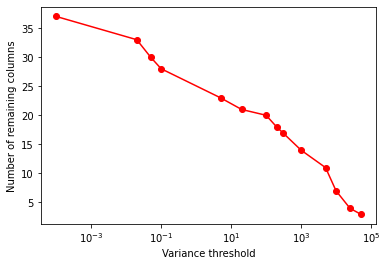

In [ ]:
plt.plot(df_feat_var['thresh']+0.0001, df_feat_var['n_rem_cols'],  '-or')

ax = plt.gca()
ax.set_xlabel('Variance threshold')
ax.set_ylabel('Number of remaining columns')
ax.set_xscale('log')
# ax.set_yscale('log')

A lot of feature have low variance, but it is partially due to the scale of the data. Let's try several quantitative transformations to see if the variance of these data can be increased. 

In [ ]:
# Transformation and encoding
ct1 = CustTransformer(strat_low_card='ohe', # One_Hot enc for categorical
                     strat_quant='none') # no transformation
df_enc = ct1.fit_transform(df_cust_vif)

print("------STANDARDIZATION-------")
ct2 = CustTransformer(strat_binary='ord',
                      strat_low_card='none', 
                      strat_quant='stand') # Standardization
df_enc_trans_A = ct2.fit_transform(df_enc)
th_A = np.arange(0,1.05,0.05)
df_res_A = check_feature_variance(th_A, df_enc_trans_A)

print("------QUANTILE NORMALISATION (norm)-------")
ct2 = CustTransformer(strat_binary='ord',
                      strat_low_card='none', 
                      strat_quant='quant_norm') # Standardization
df_enc_trans_B = ct2.fit_transform(df_enc)
th_B = np.arange(0,1.05,0.05)
df_res_B = check_feature_variance(th_B, df_enc_trans_B)

print("------QUANTILE NORMALISATION (unif)-------")
ct2 = CustTransformer(strat_binary='ord',
                      strat_low_card='none', 
                      strat_quant='quant_uni') # Standardization
df_enc_trans_C = ct2.fit_transform(df_enc)
th_C = np.arange(0,0.2,0.01)
df_res_C = check_feature_variance(th_C, df_enc_trans_C)

------STANDARDIZATION-------
thresh=0.0 -> 0 excluded cols and 0 new ones: []
thresh=0.05 -> 3 excluded cols and 3 new ones: ['binary__binary__single_purch', 'binary__binary__paytype_not_defined_tot_nb', 'binary__low_card__cust_region_3']
thresh=0.1 -> 5 excluded cols and 2 new ones: ['binary__low_card__cust_region_4', 'binary__low_card__cust_region_5']
thresh=0.15000000000000002 -> 6 excluded cols and 1 new ones: ['binary__low_card__cust_region_2']
thresh=0.2 -> 6 excluded cols and 0 new ones: []
thresh=0.25 -> 7 excluded cols and 1 new ones: ['binary__low_card__cust_region_1']
thresh=0.30000000000000004 -> 7 excluded cols and 0 new ones: []
thresh=0.35000000000000003 -> 7 excluded cols and 0 new ones: []
thresh=0.4 -> 7 excluded cols and 0 new ones: []
thresh=0.45 -> 7 excluded cols and 0 new ones: []
thresh=0.5 -> 7 excluded cols and 0 new ones: []
thresh=0.55 -> 7 excluded cols and 0 new ones: []
thresh=0.6000000000000001 -> 7 excluded cols and 0 new ones: []
thresh=0.65 -> 7 exclu

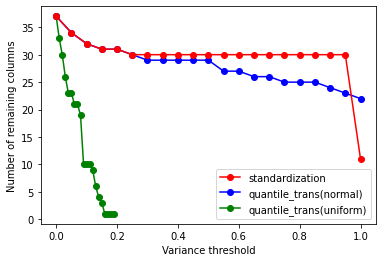

In [ ]:
plt.plot(df_res_A['thresh']+0.0001, df_res_A['n_rem_cols'],
         '-or', label='standardization', zorder=10)
plt.plot(df_res_B['thresh']+0.0001, df_res_B['n_rem_cols'],
         '-ob', label='quantile_trans(normal)', zorder=5)
plt.plot(df_res_C['thresh']+0.0001, df_res_C['n_rem_cols'],
         '-og', label='quantile_trans(uniform)', zorder=1)

ax = plt.gca()
ax.set_xlabel('Variance threshold')
ax.set_ylabel('Number of remaining columns')
# ax.set_xscale('log')
ax.legend()
# ax.set_yscale('log')
plt.show()


Apart from 'mean_nb_items_per_ord' and 'single_purch, most of the low variance columns are, without surprise, dummy columns (region, payment type and category).
We will nevertheless keep the columns for the moment and try a feature selection.


#### PCA

In [ ]:
# Data selection
sel_cols = [c for c in df_cust_vif.columns \
            if not (('cat_' in c)\
                    or ('paytype' in c)\
                    or ('reg' in c))]
print("Columns excluded :\n",
      [c for c in df_cust_vif if c not in sel_cols])
print("Columns included :\n", sel_cols)

# Transformation and encoding
ct1 = CustTransformer(strat_low_card='ohe',
                      strat_quant='quant_norm')
ct2 = CustTransformer(strat_quant='stand')
df_sel_trans = ct2.fit_transform(ct1.fit_transform(df_cust_vif[sel_cols]))

Columns excluded :
 ['cust_region', 'paytype_not_defined_tot_nb', 'paytype_boleto_tot_nb', 'paytype_voucher_tot_nb', 'paytype_debit_card_tot_nb', 'cat_multimedia_tot_nb', 'cat_office_tot_nb', 'cat_leisure_tot_nb', 'cat_home_tot_nb', 'cat_food_tot_nb', 'cat_unknown_tot_nb', 'cat_diy_tot_nb', 'cat_electronics_tot_nb', 'cat_furniture_tot_nb', 'cat_hygiene_tot_nb', 'cat_fashion_tot_nb', 'cat_miscellaneous_tot_nb', 'cat_books_tot_nb']
Columns included :
 ['mean_nb_items_per_ord', 'mean_freight_val_per_order', 'tot_price', 'avg_freight_payval_ratio', 'tot_nb_ord', 'mean_ship_time', 'single_purch', 'nb_not_rec_orders', 'time_since_last_purch', 'mean_prod_vol_cm3', 'mean_prod_descr_length', 'mean_prod_wei_g', 'mean_comment_length', 'mean_rev_score', 'mean_pay_install']


In [ ]:
from sklearn.decomposition import PCA

n_comp = len(df_sel_trans.columns)
pca = PCA(n_components=n_comp).fit(df_sel_trans)

# Performing pca
pca_comp = pd.DataFrame(pca.components_,
                        index=['PC'+str(i+1) for i in range(n_comp)],
                        columns=sel_cols).T

# Projection of the dataframe on all pca axes
df_proj_PCA = pd.DataFrame(pca.transform(df_sel_trans),
                           index=df_sel_trans.index,
                           columns=['PC'+str(i) for i in range(n_comp)])

Plotting heat map of the principal components

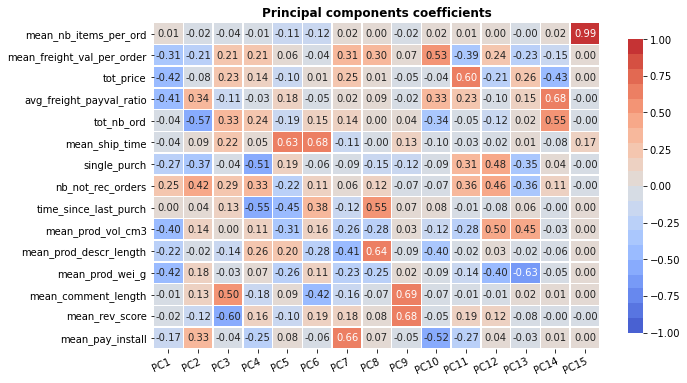

In [ ]:
plot_heatmap(pca_comp,'Principal components coefficients',
             vmin=-1, vmax=1, center=0,
             palette=sns.color_palette("coolwarm", 20),
             figsize=(10,6),shape='rect')
plt.show()

Plotting explained variance ratio in scree plot

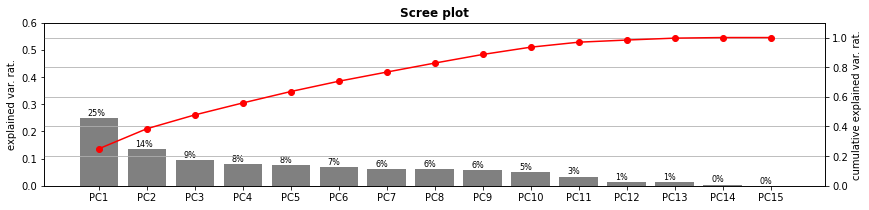

In [ ]:
exp_var_rat = pca.explained_variance_ratio_
scree_plot(col_names= pca_comp.columns, exp_var_rat=exp_var_rat,
           ylim=(0,0.6), figsize=(14,3))
plt.grid()
plt.show()

Without the dummy columns, 80% of the variance of the 15 columns is in the 8 first principal components.
With a quantile transformation (normal) before the standardization, more variance can be obtained on the first axes.

#### UMAP

In [ ]:
# Data selection
sel_cols = [c for c in df_cust_vif.columns \
            if not (('cat_' in c)\
                    or ('paytype' in c)\
                    or ('reg' in c))]
print("Columns excluded :\n",
      [c for c in df_cust_vif if c not in sel_cols])
print("Columns included :\n", sel_cols)

# Transformation and encoding
ct1 = CustTransformer(strat_low_card='ohe',
                      strat_quant='quant_norm')
ct2 = CustTransformer(strat_quant='stand')
df_sel_trans = ct2.fit_transform(ct1.fit_transform(df_cust_vif[sel_cols]))

Columns excluded :
 ['cust_region', 'paytype_not_defined_tot_nb', 'paytype_boleto_tot_nb', 'paytype_voucher_tot_nb', 'paytype_debit_card_tot_nb', 'cat_multimedia_tot_nb', 'cat_office_tot_nb', 'cat_leisure_tot_nb', 'cat_home_tot_nb', 'cat_food_tot_nb', 'cat_unknown_tot_nb', 'cat_diy_tot_nb', 'cat_electronics_tot_nb', 'cat_furniture_tot_nb', 'cat_hygiene_tot_nb', 'cat_fashion_tot_nb', 'cat_miscellaneous_tot_nb', 'cat_books_tot_nb']
Columns included :
 ['mean_nb_items_per_ord', 'mean_freight_val_per_order', 'tot_price', 'avg_freight_payval_ratio', 'tot_nb_ord', 'mean_ship_time', 'single_purch', 'nb_not_rec_orders', 'time_since_last_purch', 'mean_prod_vol_cm3', 'mean_prod_descr_length', 'mean_prod_wei_g', 'mean_comment_length', 'mean_rev_score', 'mean_pay_install']


In [295]:
from umap import UMAP

df = df_sel_trans

n_comp = len(df.columns)

# UMAP instantiation
umap = UMAP(n_components=n_comp, n_neighbors=15, min_dist=0.1, init='spectral',
            random_state=14)

# Fitting the model, projecting data on UMAP axes
df_proj_UMAP = pd.DataFrame(umap.fit_transform(df),
                           index=df.index,
                           columns=['UMAP'+str(i) for i in range(n_comp)])

### 1.3 Preparing the axes for visualisation

In [ ]:
# Data selection
sel_cols = [c for c in df_cust_vif.columns \
            if not (('cat_' in c)\
                    or ('paytype' in c)\
                    or ('reg' in c))]
print("Columns excluded :\n",
      [c for c in df_cust_vif if c not in sel_cols])
print("Columns included :\n", sel_cols)

# Transformation and encoding
ct1 = CustTransformer(strat_low_card='ohe',
                      strat_quant='quant_norm')
ct2 = CustTransformer(strat_quant='stand')

df_sel_trans = ct2.fit_transform(ct1.fit_transform(df_cust_vif[sel_cols]))

# Sampling
ind_sample = df_sel_trans.sample(1000, random_state=14).index
df = df_sel_trans.loc[ind_sample]

Columns excluded :
 ['cust_region', 'paytype_not_defined_tot_nb', 'paytype_boleto_tot_nb', 'paytype_voucher_tot_nb', 'paytype_debit_card_tot_nb', 'cat_multimedia_tot_nb', 'cat_office_tot_nb', 'cat_leisure_tot_nb', 'cat_home_tot_nb', 'cat_food_tot_nb', 'cat_unknown_tot_nb', 'cat_diy_tot_nb', 'cat_electronics_tot_nb', 'cat_furniture_tot_nb', 'cat_hygiene_tot_nb', 'cat_fashion_tot_nb', 'cat_miscellaneous_tot_nb', 'cat_books_tot_nb']
Columns included :
 ['mean_nb_items_per_ord', 'mean_freight_val_per_order', 'tot_price', 'avg_freight_payval_ratio', 'tot_nb_ord', 'mean_ship_time', 'single_purch', 'nb_not_rec_orders', 'time_since_last_purch', 'mean_prod_vol_cm3', 'mean_prod_descr_length', 'mean_prod_wei_g', 'mean_comment_length', 'mean_rev_score', 'mean_pay_install']


In [ ]:
# PCA

from sklearn.decomposition import PCA

# Performing pca
pca = PCA(n_components=2).fit(df)

# Projection of the sample dataframe on the 2 first pca axes
df_proj_PCA_2D = pd.DataFrame(pca.transform(df),
                              index=df.index,
                              columns=['PC'+str(i) for i in range(2)])

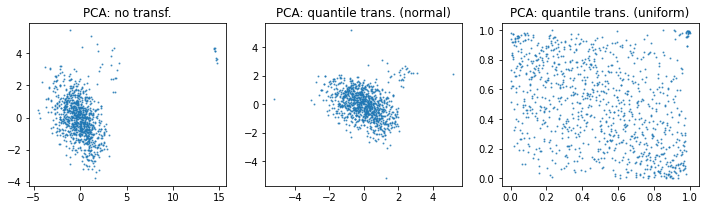

In [ ]:
plot_projection(df_proj_PCA_2D, ser_clust=None, quant_transf=True,
             figsize=(12,3), title='PCA')

In [ ]:
# UMAP

from umap import UMAP

# Instantiation of UMAP
umap = UMAP(n_components=2, random_state=14)

# Projection of the dataframe on the 2 UMAP axes
df_proj_UMAP_2D = pd.DataFrame(umap.fit_transform(df),
                               index=df.index,
                               columns=['UMAP'+str(i) for i in range(2)])

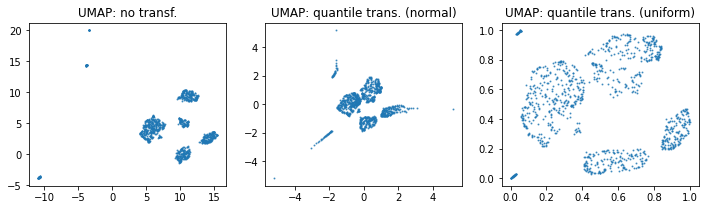

In [ ]:
plot_projection(df_proj_UMAP_2D, ser_clust=None, quant_transf=True,
             figsize=(12,3), title='UMAP')

In [ ]:
# TESTING FOR n_neighbors=15

ind_sample = df_cust_trans.sample(1000, random_state=14).index

fig = plt.figure(figsize=(18,3))
n_neigh_list = [5, 10, 20, 50, 100, 200]
for i, n in enumerate(n_neigh_list,1):
    draw_umap(data=df,
            #   ser_clust=ser_clust.loc[ind_sample],#
              n_neighbors=n,
              fig=fig,
              layout=str(1)+str(len(n_neigh_list))+str(i),
              title='n_neighbors = {}'.format(n),
              s=1, alpha=0.6,
              random_state=14)
fig.suptitle("UMAP : Testing for best nb neighbors",
             fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.9])
plt.show()

# TESTING FOR min_dist=0.1

fig = plt.figure(figsize=(18,3))
min_dist_list = [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]
for i, d in enumerate(min_dist_list,1):
    draw_umap(data=df,
            #   ser_clust=ser_clust.loc[ind_sample],#
              n_neighbors=100, min_dist=d,
              fig=fig,
              layout=str(1)+str(len(min_dist_list))+str(i),
              title='min_dist = {}'.format(d),
              s=1, alpha=0.6,
              random_state=14)
fig.suptitle("UMAP : Testing for best min distance",
             fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.9])
plt.show()

NameError: ignored

<Figure size 1296x216 with 0 Axes>

In [ ]:
# TESTING FOR n_components

fig = plt.figure(figsize=(18,5))
n_comp_list = [1,2,3]
for i, a in enumerate(n_comp_list,1):
    draw_umap(data=df_cust_trans.loc[ind_sample],
              ser_clust=ser_clust.loc[ind_sample],#
              n_neighbors=100, min_dist=0.8,
              n_components=a,
              fig=fig, layout=str(1)+str(len(n_comp_list))+str(i),
              title='min_dist = {}'.format(a),
              s=3, alpha=0.6,
              random_state=14)
fig.suptitle("UMAP : Testing for best min distance",
             fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.9])
plt.show()

In [ ]:
# t-SNE

from sklearn.manifold import TSNE

# Fitting the model
tsne = TSNE(n_components=2, random_state=14)

# Projection of the dataframe on the 2 t-SNE axes
df_proj_tSNE_2D = pd.DataFrame(tsne.fit_transform(df),
                               index=df.index,
                               columns=['t-SNE'+str(i) for i in range(2)])

In [ ]:
plot_projection(df_proj_tSNE_2D, ser_clust=None, quant_transf=True,
                figsize=(12,3), title='t-SNE')

### 1.4 Preparing data before clustering

#### All the variables, standardisation (df1)

In [ ]:
# Data selection
# df_cust_vif : data without colinear features

# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                      strat_quant='stand')

df_sel_trans = ct.fit_transform(df_cust_vif)

# Sampling
ind_sample = df_sel_trans.sample(1000, random_state=14).index
df1 = df_sel_trans.loc[ind_sample]

#### Without the dummy columns, standardization (df2)

In [ ]:
# Data selection
# without dummy columns
sel_cols = [c for c in df_cust_vif.columns \
            if not (('cat_' in c)\
                    or ('paytype' in c)\
                    or ('reg' in c))]
print("Columns excluded :\n",
      [c for c in df_cust_vif if c not in sel_cols])
print("Columns included :\n", sel_cols)

# Transformation and encoding
ct1 = CustTransformer(strat_low_card='ohe',
                      strat_quant='quant_norm')
ct2 = CustTransformer(strat_quant='stand')

df_sel_trans = ct2.fit_transform(ct1.fit_transform(df_cust_vif[sel_cols]))

# Sampling
ind_sample = df_sel_trans.sample(1000, random_state=14).index
df2 = df_sel_trans.loc[ind_sample]

#### Without dummy columns, standardisation, 8 first axes of a PCA (df3)

In [ ]:
# Data selection
# without dummy columns

sel_cols = [c for c in df_cust_vif.columns \
            if not (('cat_' in c)\
                    or ('paytype' in c)\
                    or ('reg' in c))]
print("Columns excluded :\n",
      [c for c in df_cust_vif if c not in sel_cols])
print("Columns included :\n", sel_cols)

# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                      strat_quant='stand')
df_sel_trans = ct.fit_transform(ct.fit_transform(df_cust_vif[sel_cols]))

# Performing pca
n_comp = 8
pca = PCA(n_components=n_comp).fit(df_sel_trans)
pca_comp = pd.DataFrame(pca.components_,
                        index=['PC'+str(i+1) for i in range(n_comp)],
                        columns=sel_cols).T
df_proj_PCA = pd.DataFrame(pca.transform(df_sel_trans),
                           index=df_sel_trans.index,
                           columns=['PC'+str(i) for i in range(n_comp)])

# Sampling
ind_sample = df_proj_PCA.sample(1000, random_state=14).index
df3 = df_proj_PCA.loc[ind_sample]

#### Without dummy columns, standardisation, 8 first axes of UMAP (df4)

In [305]:
# Data selection
# without dummy columns

sel_cols = [c for c in df_cust_vif.columns \
            if not (('cat_' in c)\
                    or ('paytype' in c)\
                    or ('reg' in c))]
print("Columns excluded :\n",
      [c for c in df_cust_vif if c not in sel_cols])
print("Columns included :\n", sel_cols)

# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                      strat_quant='stand')
df_sel_trans = ct.fit_transform(ct.fit_transform(df_cust_vif[sel_cols]))

# Performing pca
n_comp = 8
umap = UMAP(n_components=n_comp, n_neighbors=15, min_dist=0.1, init='spectral',
            random_state=14)

# Fitting the model, projecting data on UMAP axes
df_proj_UMAP = pd.DataFrame(umap.fit_transform(df_sel_trans),
                            index=df_sel_trans.index,
                            columns=['UMAP'+str(i) for i in range(n_comp)])

# Sampling
ind_sample = df_proj_UMAP.sample(1000, random_state=14).index
df4 = df_proj_UMAP.loc[ind_sample]

Columns excluded :
 ['cust_region', 'paytype_not_defined_tot_nb', 'paytype_boleto_tot_nb', 'paytype_voucher_tot_nb', 'paytype_debit_card_tot_nb', 'cat_multimedia_tot_nb', 'cat_office_tot_nb', 'cat_leisure_tot_nb', 'cat_home_tot_nb', 'cat_food_tot_nb', 'cat_unknown_tot_nb', 'cat_diy_tot_nb', 'cat_electronics_tot_nb', 'cat_furniture_tot_nb', 'cat_hygiene_tot_nb', 'cat_fashion_tot_nb', 'cat_miscellaneous_tot_nb', 'cat_books_tot_nb']
Columns included :
 ['mean_nb_items_per_ord', 'mean_freight_val_per_order', 'tot_price', 'avg_freight_payval_ratio', 'tot_nb_ord', 'mean_ship_time', 'single_purch', 'nb_not_rec_orders', 'time_since_last_purch', 'mean_prod_vol_cm3', 'mean_prod_descr_length', 'mean_prod_wei_g', 'mean_comment_length', 'mean_rev_score', 'mean_pay_install']


### 1.5 KMeans clustering

In [ ]:
from sklearn.cluster import KMeans
n=4
km = KMeans(n_clusters=n, n_jobs=-1)
km.fit(df1)
ser_clust = pd.Series(data=km.labels_,
                      index=df1.index)

# from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
# silh = silhouette_score(X=df,
#                         labels=ser_clust)
# dav_bould = davies_bouldin_score(X=df,
#                                  labels=ser_clust)
# cal_harab = calinski_harabasz_score(X=df,
#                                  labels=ser_clust)
# distor = km.inertia_
# silh, dav_bould, distor

#### Evaluation of the clustering scores

We'll try to find the best number of cluster against:

- **Silhouette score**: measures the difference between the intra-cluster and nearest-cluster mean suare distances (to maximize)
- **Davies_Bouldin score**: measures the maximal ratio of dispersion of pairs of clusters to their distance (to minimize)
- **Calinski_harabasz score**: the ratio of intra-cluster dispersion to inter-cluster dispersion (to maximize)
- **Distortion**: the mean sum of squared distances to centers (find an elbow)

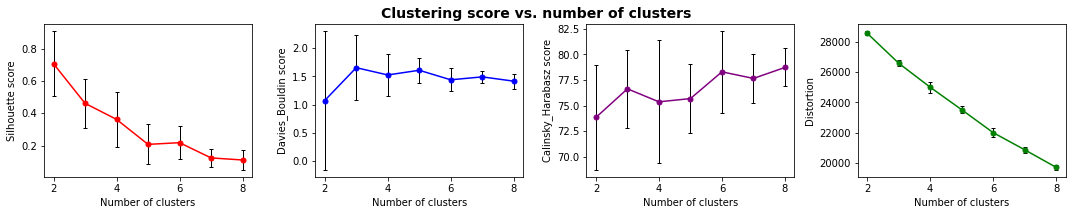

In [306]:
df1_res = plot_clust_scores_vs_n_clust(df1, n_clust=range(2,9),
                                       n_iter=20, figsize=(15,3))

In [307]:
df1_res

,2,3,4,5,6,7,8
"(Silhouette, mean)",0.71,0.46,0.36,0.21,0.22,0.12,0.11
"(Silhouette, median)",0.81,0.41,0.37,0.16,0.17,0.10,0.09
"(Silhouette, std)",0.20,0.15,0.17,0.12,0.10,0.06,0.06
"(Davies_Bouldin, mean)",1.07,1.65,1.53,1.61,1.44,1.49,1.42
"(Davies_Bouldin, median)",0.45,1.83,1.52,1.65,1.46,1.51,1.44
"(Davies_Bouldin, std)",1.23,0.57,0.38,0.22,0.21,0.10,0.13
"(Calinsky_Harabasz, mean)",73.84,76.63,75.36,75.68,78.29,77.64,78.71
"(Calinsky_Harabasz, median)",75.00,76.44,75.01,75.88,79.35,77.82,78.29
"(Calinsky_Harabasz, std)",5.12,3.82,5.98,3.35,3.97,2.35,1.85
"(Distortion, mean)",28564.35,26590.87,25007.03,23523.54,22013.92,20882.73,19723.79


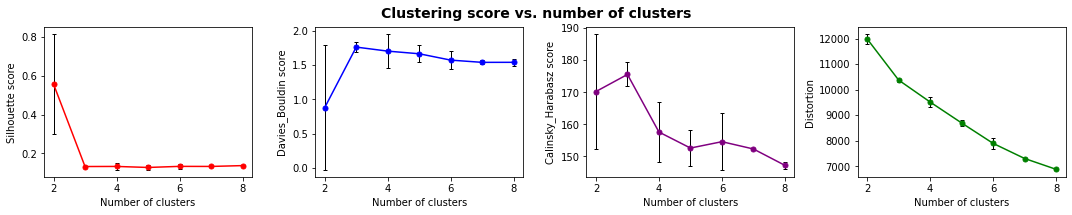

In [308]:
df2_res = plot_clust_scores_vs_n_clust(df2, n_clust=range(2,9),
                                       n_iter=20, figsize=(15,3))

In [309]:
df2_res

,2,3,4,5,6,7,8
"(Silhouette, mean)",0.56,0.13,0.13,0.13,0.13,0.13,0.14
"(Silhouette, median)",0.71,0.13,0.14,0.12,0.13,0.13,0.14
"(Silhouette, std)",0.26,0.00,0.02,0.01,0.01,0.01,0.00
"(Davies_Bouldin, mean)",0.88,1.76,1.71,1.67,1.57,1.54,1.54
"(Davies_Bouldin, median)",0.32,1.74,1.50,1.70,1.51,1.53,1.52
"(Davies_Bouldin, std)",0.91,0.07,0.25,0.13,0.13,0.03,0.05
"(Calinsky_Harabasz, mean)",170.22,175.55,157.58,152.59,154.57,152.30,147.19
"(Calinsky_Harabasz, median)",181.13,176.76,163.93,151.91,159.53,152.37,147.68
"(Calinsky_Harabasz, std)",17.91,3.73,9.34,5.50,8.83,0.24,1.08
"(Distortion, mean)",11986.21,10374.43,9515.66,8695.69,7896.30,7305.09,6880.85


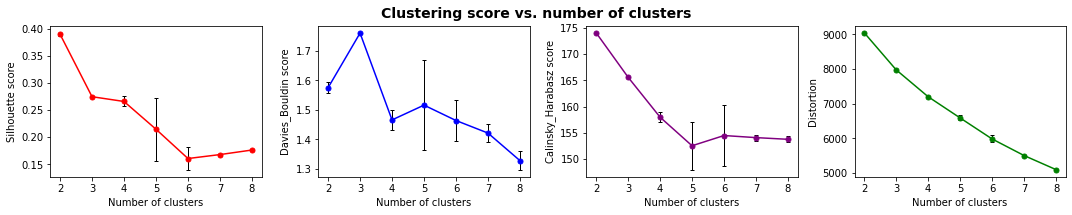

In [310]:
df3_res = plot_clust_scores_vs_n_clust(df3, n_clust=range(2,9),
                                       n_iter=20, figsize=(15,3))

In [311]:
df3_res

,2,3,4,5,6,7,8
"(Silhouette, mean)",0.39,0.27,0.27,0.21,0.16,0.17,0.18
"(Silhouette, median)",0.39,0.27,0.26,0.23,0.15,0.17,0.18
"(Silhouette, std)",0.00,0.00,0.01,0.06,0.02,0.00,0.00
"(Davies_Bouldin, mean)",1.58,1.76,1.47,1.52,1.46,1.42,1.33
"(Davies_Bouldin, median)",1.57,1.76,1.46,1.61,1.44,1.41,1.32
"(Davies_Bouldin, std)",0.02,0.00,0.03,0.15,0.07,0.03,0.03
"(Calinsky_Harabasz, mean)",174.10,165.60,157.96,152.50,154.45,154.05,153.73
"(Calinsky_Harabasz, median)",174.11,165.60,158.29,149.78,157.52,154.20,153.91
"(Calinsky_Harabasz, std)",0.03,0.01,0.93,4.62,5.84,0.59,0.54
"(Distortion, mean)",9050.11,7978.48,7202.17,6590.14,5983.32,5504.86,5098.36


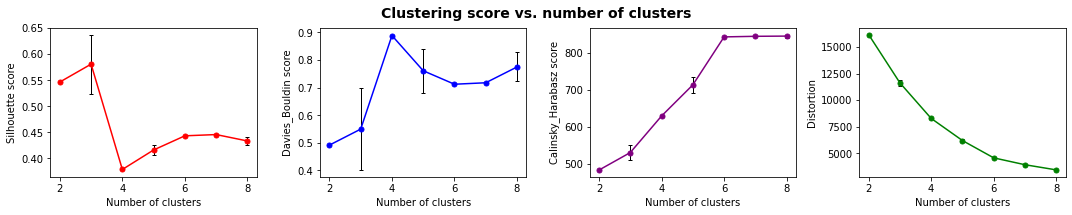

In [312]:
df4_res = plot_clust_scores_vs_n_clust(df4, n_clust=range(2,9),
                                       n_iter=20, figsize=(15,3))

In [313]:
df4_res

,2,3,4,5,6,7,8
"(Silhouette, mean)",0.55,0.58,0.38,0.42,0.44,0.45,0.43
"(Silhouette, median)",0.55,0.59,0.38,0.41,0.44,0.45,0.43
"(Silhouette, std)",0.00,0.06,0.00,0.01,0.00,0.00,0.01
"(Davies_Bouldin, mean)",0.49,0.55,0.89,0.76,0.71,0.72,0.77
"(Davies_Bouldin, median)",0.49,0.52,0.89,0.72,0.71,0.72,0.79
"(Davies_Bouldin, std)",0.00,0.15,0.00,0.08,0.00,0.00,0.05
"(Calinsky_Harabasz, mean)",482.70,530.15,629.27,713.60,843.74,845.33,845.91
"(Calinsky_Harabasz, median)",482.70,534.80,629.96,725.40,843.74,845.35,847.22
"(Calinsky_Harabasz, std)",0.00,20.79,3.08,20.96,0.00,0.06,3.92
"(Distortion, mean)",16158.05,11622.74,8279.97,6199.49,4571.42,3925.06,3439.98


#### Silhouette scores of each cluster

Let's now see in more details the silhouette scores of each cluster, for the different number of clusters.

On the left part of the graph, the silhouette coefficient is plotted for each number of clusters:
- the length of the bands is proportionnal to the size of the cluster
- the width of the small bars are the distance of each point to the closest centroid
On the right a representation of the clusters on UMAP projection of the data.

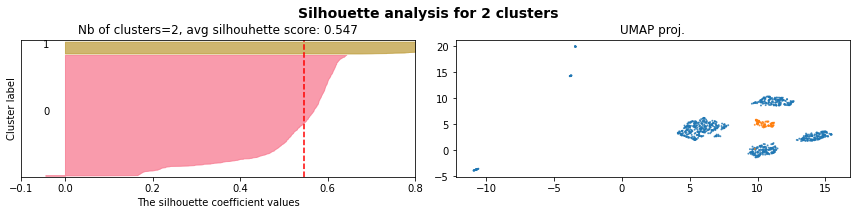

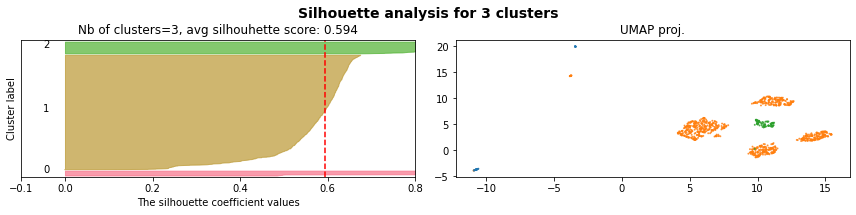

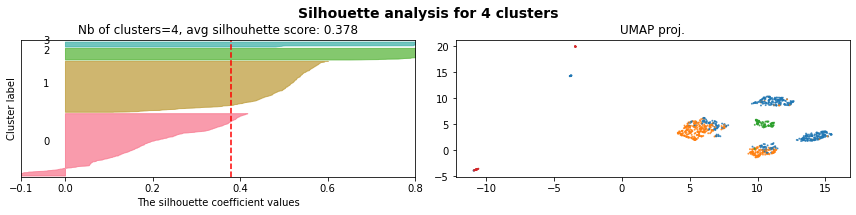

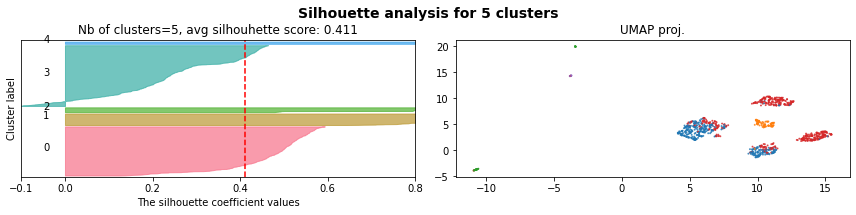

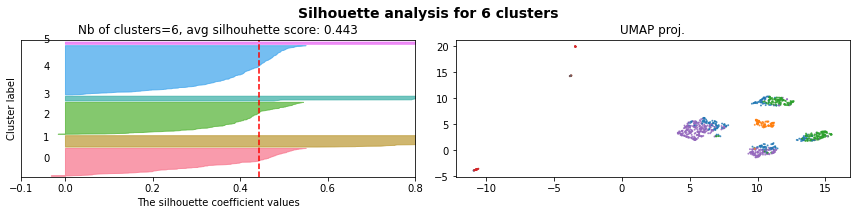

In [384]:
# silh_scores_vs_n_clust(df4, n_clust=[2,3,4,5,6], xlim=(-0.2,0.4), figsize=(14,3))
silh_scores_vs_n_clust(df4, n_clust=[2,3,4,5,6], axis_2D=df_proj_UMAP_2D,
                       xlim=(-0.1,0.8), figsize=(12,3), title='UMAP proj.')

#### Visualisation of the best clusters

In [314]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [339]:
from sklearn.cluster import KMeans

n=3
km = KMeans(n_clusters=n, n_jobs=-1)
km.fit(df4)
ser_clust = pd.Series(data=km.labels_,
                      index=df4.index)

silh = silhouette_score(X=df4, labels=ser_clust)
dav_bould = davies_bouldin_score(X=df4, labels=ser_clust)
cal_harab = calinski_harabasz_score(X=df4, labels=ser_clust)
distor = km.inertia_
silh, dav_bould, distor

(0.59355533, 0.5165844602749393, 11565.573563682057)

In [362]:
# ### EBAUCHE TRACAGE DES CENTROIDES
# n = 3
# centroid_df = pd.DataFrame(data = km.cluster_centers_,
#                            columns = df4.columns,
#                            index = ['centroid_'+str(i) for i in range(1,n+1)])
# test = pd.concat([df4, centroid_df], 0)
# test.loc[['centroid_'+str(i) for i in range(1,n+1)]]

,UMAP0,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7
centroid_1,0.41,2.13,7.98,5.09,3.08,2.80,4.85,3.48
centroid_2,10.03,5.86,5.45,6.85,5.88,4.27,4.97,3.80
centroid_3,10.70,5.03,5.87,6.82,5.71,-5.45,4.99,3.20


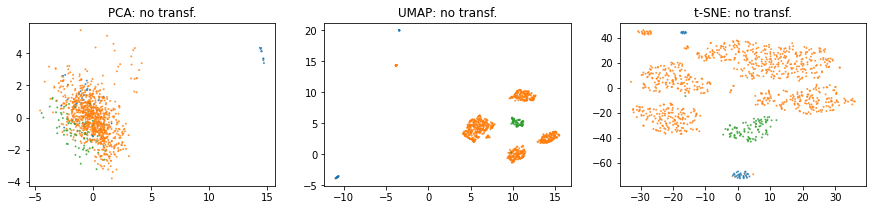

In [340]:
fig = plt.figure(figsize=(15,3))

ax1 = fig.add_subplot(131)
plot_projection(df_proj_PCA_2D, ser_clust=ser_clust, quant_transf=False,
                title='PCA', fig=fig, ax=ax1)

ax2 = fig.add_subplot(132)
plot_projection(df_proj_UMAP_2D, ser_clust=ser_clust, quant_transf=False,
                title='UMAP', fig=fig, ax=ax2)

ax3 = fig.add_subplot(133)
plot_projection(df_proj_tSNE_2D, ser_clust=ser_clust, quant_transf=False,
                title='t-SNE', fig=fig, ax=ax3)
plt.show()

#### Checking for the stability of the clusters

In [454]:
stab_init_kmeans = stability(km, df4, n_iter=10, mode='init')
stab_samp_kmeans = stability(km, df4, n_iter=10, mode='samp', n_samp=700)

--- Testing for initialisation stability (10 iterations) ---
Evaluation of stability with random init :
        mean:1.0 , std: 0.0 
--- Testing for stability with 700 lines random samples (training set) (10 iterations) ---
Evaluation of stability with random init :
        mean:1.0 , std: 0.0 


## 2 Clusters analysis

In [ ]:
df4.shape, ser_clust

In [ ]:
## Creating table of contingency

data_crosstab = pd.crosstab(clust, 
                            df_cust['nb_not_rec_orders'],  
                               margins = True)

plot_heatmap(data_crosstab,"Contingency table ('nutrigrade' vs. 'cluster_Kmeans')",
             vmin=0, vmax=1000, palette=sns.color_palette("coolwarm", 20),
             figsize=(8,4), shape='rect', fmt='.0f')
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_4_2_nutrig_clusters.png', dpi=400);
plt.show()

In [ ]:
# Contingency table showing cluster vs. pnns1 categories

data_crosstab = pd.crosstab(df['pnns1'], 
                            df['cluster_Kmeans'],  
                               margins = True)
# display(data_crosstab

# Chi-Squared Test
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(data_crosstab)
print('---'+"Chi-squared")
print('stat=%.3f, p=%.3f' % (stat, p))
print('Probably independent') if p > 0.05 else print('Probably dependent')

pca_df = pd.DataFrame(pca.components_,
                      index=['PC'+str(i+1) for i in range(n_comp)],
                      columns=pca_cols).T
plot_heatmap(data_crosstab,"Contingency table ('clusters' vs. 'pnns1')",
             vmin=0, vmax=1000,figsize=(10,4),shape='rect', fmt='.0f',
             palette=sns.color_palette("coolwarm", 20))
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_4_2_cont_tabl_clust_pnns1.png',
                             dpi=400);
plt.show()

#### Table de contingence et proportion

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.cluster import KMeans
from IPython.display import display

def kmeans_analysis(k, original_data, scaled_data, palette):
    '''Perform Kmeans on the scaled data and return the Kmeans model.
       Display features importance, population and revenue contribution for each segment.
    
    Parameters
    ----------
    k : Number of clusters to use (integer)
    original_data : Data without transformation, will be use to interpret segment (dataframe)
    scaled_data : Data after tansformation, will be use to determine segment with Kmeans (dataframe)
    palette : palette name to use for the 2 donuts graph (string)
        
    Returns
    -------
    kmeans : Kmeans model calculated with k clusters.
    
    '''
    
    # Computing Kmeans with k clusters on scaled data
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(scaled_data)
    
    # Assign segment to each customer in original dataset
    data_kmeans = original_data.assign(segment=kmeans.labels_)
    
    # Compute average for each feature by segment
    kmeans_averages = data_kmeans.groupby(['segment']).mean().round(2)
    print('Moyennes par segment : ')
    display(kmeans_averages)
    print("\n")
    
    # Compute relative importance for each feature by segment
    relative_imp = kmeans_averages / original_data.mean() - 1
    relative_imp.round(2)
    
    # Compute % of population in each segment
    pop_perc = data_kmeans['segment'].value_counts() / data_kmeans.shape[0] * 100
    pop_perc.sort_index(inplace=True)
    
    # Compute revenue for each segment
    segment_value = data_kmeans.groupby('segment')['order_value'].sum()
    
    # Create figure with 3 subplots
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    col = cm.get_cmap(palette, k)
    
    # Creation of graph displaying features importance for each segment
    sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdBu_r', ax=axs[0])
    axs[0].set_title('Importance relative des features', pad=20)
    axs[0].set_ylabel(ylabel='Segment', labelpad = 20)
    
    # Creation of graph displaying relative population for each segment
    axs[1].pie(pop_perc, autopct='%1.0f%%', pctdistance=0.82, colors=col.colors, textprops=dict(color="w"))
    axs[1].set_title('Proportion des segments', pad=20)
    f_circle=plt.Circle( (0,0), 0.65, color='white')
    axs[1].add_patch(f_circle)
    
    # # Creation of graph displaying relative revenue for each segment
    # axs[2].pie(segment_value, autopct='%1.0f%%', pctdistance=0.82, colors=col.colors, textprops=dict(color="w"))
    # axs[2].legend(labels=segment_value.index, loc='center right', bbox_to_anchor=(1.25, 0.5))
    # axs[2].set_title('Contribution de chaque segment au CA', pad=20)
    # s_circle=plt.Circle( (0,0), 0.65, color='white')
    # axs[2].add_patch(s_circle)
    
    return(kmeans)

ANOVA pour trouver les variables déterminantes

In [ ]:
# %%flake8  # checking PEP8 compliance

def get_significant_features(dataframe, categorical_labels, threshold=0.05):
    """This function proceed to a "1 variable - ANOVA" test
    for each feature in the dataframe and returns a list
    of p-values for the Fischer statistic."""

    # load libraries
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    import statsmodels.formula.api as smf
    import statsmodels.api as sm

    # categorical feature (labels) to test against
    clusters_labels = categorical_labels

    # initialize pd.DataFrame for results
    results_anova = pd.DataFrame()

    # create a pd.DataFrame with features and labels
    data_anova = pd.concat([dataframe, clusters_labels], axis=1)

    # iterating of features
    for feature_name in dataframe.columns:

        # create the model for the "1-variable ANOVA"
        formula = feature_name + "~" + "cluster_labels"
        anova_feature = smf.ols(formula, data=data_anova).fit()

        # get the p-value for the test statistic (Fisher)
        p_value = sm.stats.anova_lm(anova_feature, typ=2)['PR(>F)'][0]

        # Save the p-value for the test in a pd.DataFrame
        results_anova.loc[feature_name, 'p-value'] = p_value
        results_anova.loc[feature_name, 'significant'] = (p_value < threshold)

    # return pd.DataFrame of results
    return results_anova

In [ ]:
# %%flake8  # checking PEP8 compliance

# Setup before calling the function
dataframe = scaled_features
categorical_labels = clusters_labels

# Proceed to the "1 variable ANOVA test"
results_anova = get_significant_features(
    dataframe,
    categorical_labels,
    threshold=0.05
)

# Displays results of ANOVA analysis
display(results_anova)

# Get the significant features (above threshold)
threshold = 0.05
mask = (results_anova['p-value'] < threshold)
significant_features = results_anova[mask].index

In [ ]:
# %%flake8  # checking PEP8 compliance

# Keep only the significant features for Kiviat diagrams
mask_features = scaled_features.columns.isin(significant_features)
scaled_features = scaled_features.loc[:, mask_features]

# Display head of remaining data
scaled_features.head(3)

#### Diagrammes en Radar

In [ ]:
# %%flake8  # checking PEP8 compliance


def kiviat_diagram(cluster_index):

    # Get features names
    features_names = list(numerical_features)

    # Get number of variables
    num_vars = len(features_names)

    # Split the circle into even parts and save the angles
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is a circle, so we need to "complete the loop"
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # Set color
    # ----------
    # cmap = plt.cm.Dark2  # ListedColormap
    cmap = plt.cm.get_cmap('hsv')  # LinearSegmentedColormap
    NB_CLUSTERS = len(list_clusters) - (1 if -1 in clusters_labels else 0)
    color = cmap(cluster_index/NB_CLUSTERS)

    # Add cluster to the chart
    # -------------------------
    # Get values and complete the circle
    values = data_kiviat[features_names].loc[cluster_index].tolist()
    values += values[:1]
    ax.plot(
        angles,
        values,
        color=color,
        linewidth=1,
        label="Cluster #"+str(cluster_index)
    )
    ax.fill(angles, values, color=color, alpha=0.25)

    # add_to_radar(1, '#429bf4')
    # add_to_radar('mean customer', '#d42cea')

    # Add 'mean customer' to the chart
    # Get values and complete the circle
    values = data_kiviat[features_names].loc['mean customer'].tolist()
    values += values[:1]
    ax.plot(angles,
            values,
            color='black',
            linewidth=0.6,
            label='mean customer')
    # ax.fill(angles, values, color=color, alpha=0.25)

    # Fix axis to go in the right order and start at 12 o'clock.
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw axis lines for each angle and label.
    ax.set_thetagrids(np.degrees(angles), features_names)

    # Go through labels and adjust alignment based on position
    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')

    # Ensure radar goes from 0 to 100
    ax.set_ylim(0, 100)

    # Set position of y-labels (0-100)
    ax.set_rlabel_position(180 / num_vars)

    # Add some custom styling.
    # Change the color of the tick labels.
    ax.tick_params(colors='#222222')
    # Make the y-axis (0-100) labels smaller.
    ax.tick_params(axis='y', labelsize=8)
    # Change the color of the circular gridlines.
    ax.grid(color='#AAAAAA')
    # Change the color of the outermost gridline (the spine).
    ax.spines['polar'].set_color('#222222')
    # Change the background color inside the circle itself.
    ax.set_facecolor('#FAFAFA')

    # Add title
    ax.set_title('Cluster #{} profile'.format(cluster_index), y=1.08)

    # Add a legend
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    fig.savefig('plots/kiviat_cluster{}.png'.format(cluster_index))

In [ ]:
# %%flake8  # checking PEP8 compliance

# Draw Kiviat diagrams for each cluster
for cluster_index in list_clusters:
    # don't draw cluster_index for noise
    if cluster_index == -1:
        continue
    kiviat_diagram(cluster_index)

## Stabilité temporelle

In [ ]:
def calculRfmTable(data, period, end_period):

    """
    Calcul des valeurs R, F et M et assigne pour chaque client
    un score selon la méthodologie 1 et un cluster selon la méthodologie 2

    Paramètres:
    data(pd.DataFrame): DataFrame avec 3 colonnes
    Recency, Frequency et Monetary
    period(int) : Nombre de jours
    end_period(dt.datetime): Date de fin de période

    Return:
    rfmTable(pd.DataFrame): DataFrame data avec 2 nouvelles colonnes
    correspondant
    aux scores et clusters des différents clients pour les méthodologies 1 et 2

    """

    rfm = calculateRFM(data, period, end_period)
    # Calcul le quantile associé à chaque variable RFM
    # pour chaque client
    rfmTable = calculQuantile(rfm)
    # Determine pour chaque client le segment auquel il appartient
    # suivant ses quantiles pour les variables R, F et M
    rfmTable["RFM Score"] = rfmTable.apply(calculSegment, axis=1)

    # Normalise les valeurs R, F et M pour le clustering
    X_transformed = encoder.transform(rfm[["Recency",
                                           "Frequency", "Monetary"]])
    # Clustering pour chacun des clients
    clusters = kmeans.predict(X_transformed)
    rfmTable["clusters"] = clusters
    
    # Etiquettage et fusion de 3 clusters
    rfmTable.loc[rfmTable["clusters"] == 0, "clusters"] = 'Potential Good Clients'
    rfmTable.loc[rfmTable["clusters"] == 1, "clusters"] = 'Lost'
    rfmTable.loc[rfmTable["clusters"] == 2, "clusters"] = 'Average Clients'
    rfmTable.loc[rfmTable["clusters"] == 3, "clusters"] = 'Top Clients ++'
    rfmTable.loc[rfmTable["clusters"] == 4, "clusters"] = 'Good Clients'
    rfmTable.loc[rfmTable["clusters"] == 5, "clusters"] = 'Top Clients ++'
    rfmTable.loc[rfmTable["clusters"] == 6, "clusters"] = 'Top Clients ++'

    return rfmTable

In [ ]:
# Calcul RFM avec la même méthode,
# mais pour une période décalé de 30 jours en arrière
rfmTable_2 = calculRfmTable(data, period, today - timedelta(days=30))

# Calcul RFM avec la même méthode,
# mais pour une période décalé de 90 jours en arrière
rfmTable_3 = calculRfmTable(data, period, today - timedelta(days=60))

# Calcul RFM avec la même méthode,
# mais pour une période décalé de 180 jours en arrière
rfmTable_4 = calculRfmTable(data, period, today - timedelta(days=90))

In [ ]:
def stability_segments(rfmTable_ref, *rfmTable_):

    """
    Détermine la stabilité des segments suivant les 2 méthodologies
    vu précédemment
    La stabilité est défini comme le pourcentage d'individus restant
    dans le même segment d'une période à l'autre

    Paramètres:
    rfm_ref(pd.DataFrame): Segmentzation pendant la période de référence
    *rfm_(pd.DataFrame) :  Différentes segmentations correspondant
    à différentes périodes

    Return:
    df_results(pd.DataFrame): DataFrame de résultats de stabilité
    """

    stability_clusters = []
    stability_segments = []

    # Pour chaque segmentation
    for rfmTable in rfmTable_:
        
        # Calcul de la stabilité pour la segmentation par quantile
        stability_segments.append(
            round(100 * adjusted_rand_score(rfmTable_ref["RFM Score"],
                                rfmTable["RFM Score"]), 2))
        
        # Calcul de la stabilité pour la segmentation par clustering
        stability_clusters.append(
            round(100 * adjusted_rand_score(rfmTable_ref["clusters"],
                                          rfmTable["clusters"]), 2))

    # Concaténation des résultats des 2 méthodologies
    results = np.c_[stability_segments, stability_clusters]

    # Converti les données en DataFrame
    df_results = pd.DataFrame(results,
                              columns=["RFM Score", "Clusters"]
                              ).rename_axis("ARI (%)", axis=1)

    return df_results

In [ ]:
# Calcul de la stabilité des segments et des clusters
stability = stability_segments(rfmTable_1,
                               rfmTable_2,
                               rfmTable_3,
                               rfmTable_4)
# L'index est étiquetté selon les différentes périodes
stability.index = ['30 jours', '60 jours', '90 jours']
# Affichage des résultats
stability

### Sankey

In [ ]:
def sankey_data(method, *rfm):

    """
    La fonction sankey_data retourne un dictionnaire adapté au tracé
    d'un diagramme de Sankey
    Plus d'informations : https://plot.ly/python/sankey-diagram/

    Paramètres :
    method: Nom de la colonne dont les informations sont à récupérer
    *rfm: Au moins 2 DataFrame correspondant à des segmentations
    temporellement différentes

    Return :

    dict: Dictionnaire de résultats

    """

    sources = []
    targets = []
    values = []
    sankey_data = {}

    list_segments = []
    list_segments_0 = []
    list_segments_1 = []

    sankey_data["label"] = sorted(list(rfm[0][method].unique()))
    source = 0
    target = 0
    i = 0

    while i < len(rfm)-1:

        list_segments_0 = sorted(list(rfm[i][method].unique()))
        list_segments_1 = sorted(list(rfm[i + 1][method].unique()))

        list_segments.append(list_segments_1)

        sankey_data["label"] += list_segments_1

        target += len(list_segments_0)
        for segment_0 in list_segments_0:
            for segment_1 in list_segments_1:

                sources.append(list_segments_0.index(segment_0) + source)
                targets.append(list_segments_1.index(segment_1) + target)

                flow = sum(rfm[i + 1].iloc[rfm[i][rfm[i][method] ==
                           segment_0].index][method] == segment_1)

                values.append(flow)

        source += len(list_segments_0)
        i += 1

    sankey_data["source"] = sources
    sankey_data["target"] = targets
    sankey_data["value"] = values

    return sankey_data

## AUTRES ALGOS DE CLUSTERING


In [ ]:
# Hierarchical Clustering

# Z = linkage(X_sc, 'ward')
# print(Z[0:15])
# plt.figure(figsize=(16,10))
# dendrogram(Z, labels = df.index, orientation = "right", count_sort='descending')
# plt.show()

# n_clust = 6
# clustH = fcluster(Z, n_clust, criterion='maxclust')
# df['cluster_HierClust'] = clustH
# clustH